<h1><center><font size="6">Santander Customer Transaction Prediction</font></center></h1>

<h2><center><font size="4">Dataset used: Santander Customer Transaction Prediction</font></center></h2>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg" width="500"></img>

<br>

# <a id='1'>Content</a>  

- Introduction
- Exploratory Data Analysis
- Load Data and Reducing Memory Usage
- Basic Statistics Plot
- Feauture Engineering
- Regression Model (Light GBM)
- Classification Model (Logistic Regression, Naive Bayes , Random Forest)
- Feature Engineering (Sorting Fake Test Data, Frequency Encoding, K Fold CV)
- Conclusion
- Submission

# <a id='1'>Abstract</a>  

In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.  

The data is anonimyzed, each row containing 200 numerical values identified just with a number.  

In the following we will explore the data, prepare it for a model, train a model and predict the target value for the test set, then prepare a submission.


At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.



# <a id='2'>Exploratory Data Analysis</a>  



In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")


# <a id='2'> Load Data and Reducing Memory Usage</a>  

In [63]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


#### Shape of Training and Test Data

In [10]:
train = import_data("C:/Users/shali/Desktop/INFO 7390/Assignments/Assignment2/Data/train.csv")
test = import_data("C:/Users/shali/Desktop/INFO 7390/Assignments/Assignment2/Data/test.csv")

print("\n\nTrain Size : \t{}\nTest Size : \t{}".format(train.shape, test.shape))

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 83.77 MB
Decreased by 72.8%
Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 83.58 MB
Decreased by 72.7%


Train Size : 	(200000, 202)
Test Size : 	(200000, 201)


We can see that the train Dataset has 202 columns while the test Dataset has 201 Columns. The extra column in the Train Dataset is the target data set which is not present in the Test Dataset

In [57]:
train.head(2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.62500,...,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.53125,...,7.640625,7.722656,2.583984,10.953125,15.429688,2.033203,8.125000,8.789062,18.359375,1.952148


The data obtained is entirely masked so with even domain knowledge we will not be able to find out any significant features. We can try with basic features like mean, standard deviation, counts, median, etc. We will do feature engineering later.

# <a id='2'> Basic Stats</a>

### Target Distribution

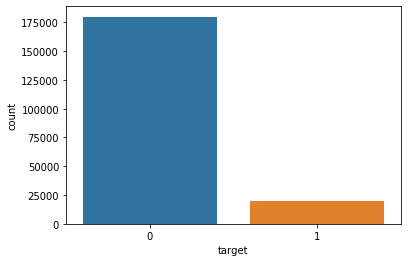

In [70]:
sns.countplot(train['target'])

In [59]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

### Is the Dataset balanced?

In [71]:
mylst = list(df_train["target"].value_counts())
zero = round(float((mylst[0]/sum(mylst))*100),2)
one = round(float((mylst[1]/sum(mylst))*100),2)
print('The dataset has {zero} % of target 0 and {one} % of target 1'.format(zero=zero, one=one))

The dataset has 89.95 % of target 0 and 10.05 % of target 1



**Well, not very balanced... we'll keep that into account!**

In [60]:
t0=train[train['target']==0]
t1=train[train['target']==1]

Distributions of 1st 100 features


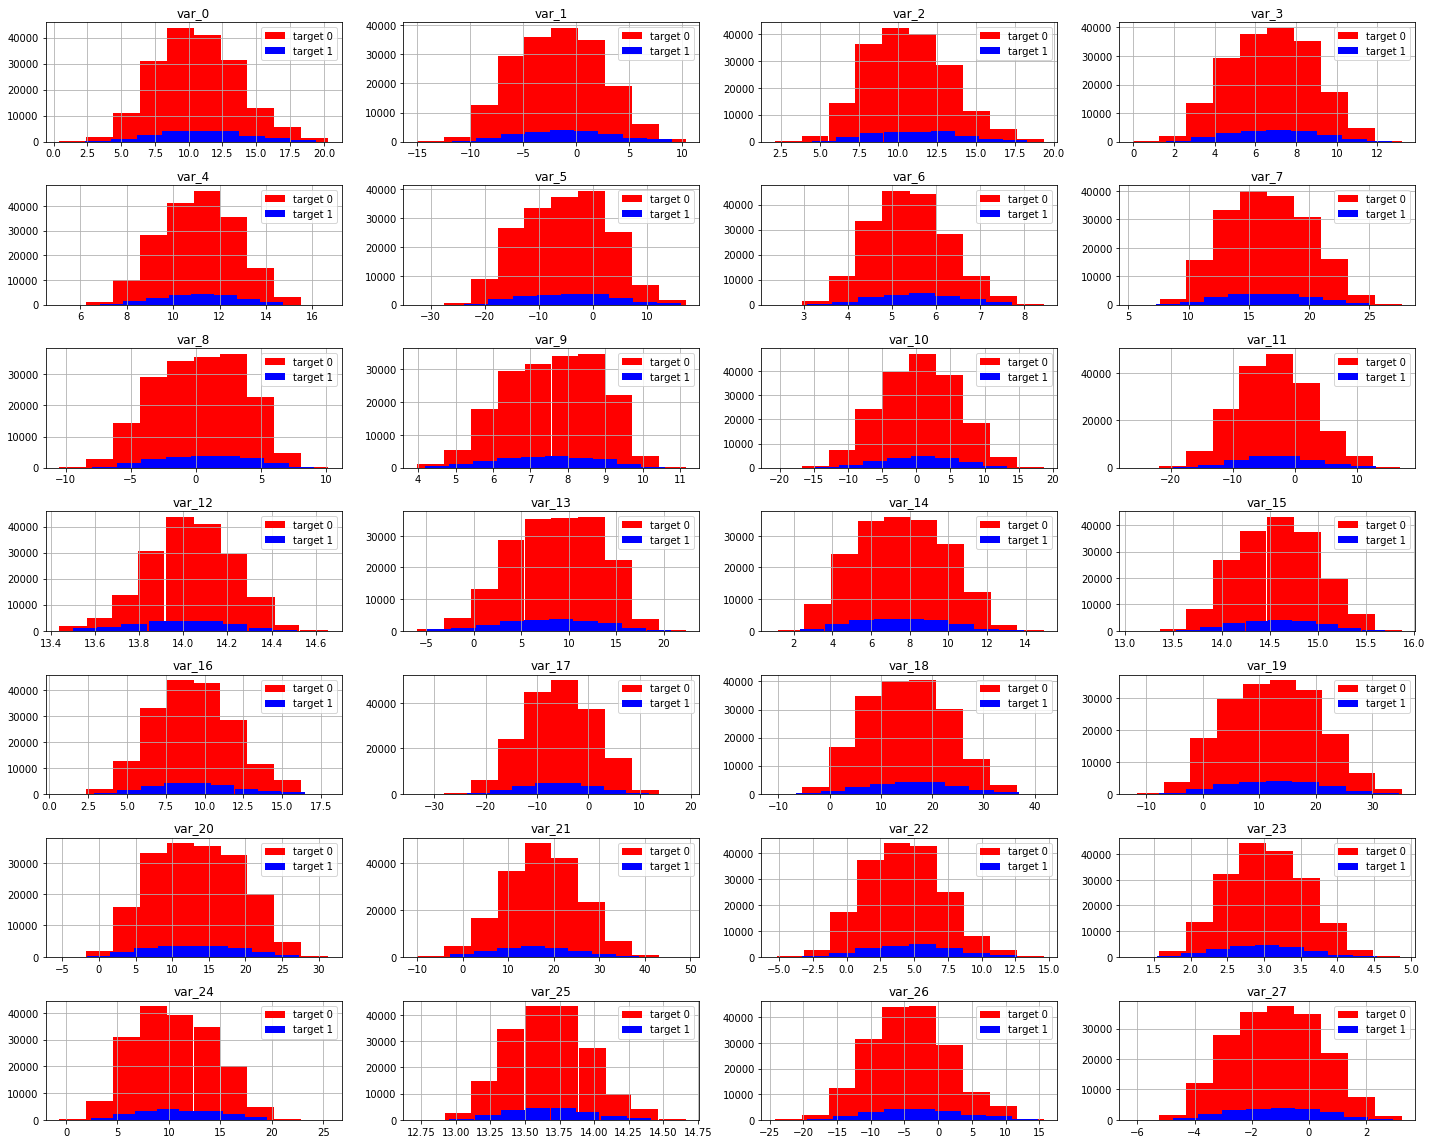

In [61]:
print('Distributions of 1st 100 features')
plt.figure(figsize=(20,16))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7,4,i + 1)
    plt.hist(t0[col],label='target 0',color='Red')
    plt.hist(t1[col],label='target 1',color='Blue')
    plt.title(col)
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()

We can see from the above that nearly 90% of the Target value is 0(we assume that 0 stands for Customer didnot do transaction) and only 10% is 1(we assume 1 stands for Customer did a Transaction).

This makes the data significantly imbalanced

In [9]:
train.drop(['ID_code'],axis=1,inplace=True)
labels=train['target']
train.drop(['target'],axis=1,inplace=True)

In [10]:
train.select_dtypes(include='float16')

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,...,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,...,7.640625,7.722656,2.583984,10.953125,15.429688,2.033203,8.125000,8.789062,18.359375,1.952148
2,8.609375,-2.746094,12.078125,7.894531,10.585938,-9.085938,6.941406,14.617188,-4.917969,5.953125,...,2.906250,9.789062,1.669922,1.685547,21.609375,3.142578,-6.519531,8.265625,14.718750,0.396484
3,11.062500,-2.152344,8.953125,7.195312,12.585938,-1.835938,5.843750,14.921875,-5.859375,8.242188,...,4.464844,4.742188,0.717773,1.421875,23.031250,-1.270508,-2.927734,10.289062,17.968750,-9.000000
4,9.835938,-1.483398,12.875000,6.636719,12.273438,2.449219,5.941406,19.250000,6.265625,7.679688,...,-1.490234,9.523438,-0.150757,9.195312,13.289062,-1.511719,3.925781,9.500000,18.000000,-8.812500
5,11.476562,-2.318359,12.609375,8.625000,10.960938,3.560547,4.531250,15.226562,3.585938,5.980469,...,-6.308594,6.601562,5.292969,0.440186,14.945312,1.031250,-3.625000,9.765625,12.578125,-4.761719
6,11.812500,-0.083191,9.351562,4.292969,11.132812,-8.023438,6.195312,12.078125,-4.378906,7.921875,...,8.781250,6.453125,3.533203,0.177734,18.328125,0.584473,9.109375,9.117188,10.890625,-3.208984
7,13.554688,-7.988281,13.875000,7.597656,8.656250,0.831055,5.687500,22.328125,5.066406,7.195312,...,13.171875,6.550781,3.990234,5.804688,23.140625,-0.377686,4.218750,9.421875,8.664062,3.480469
8,16.109375,2.443359,13.929688,5.632812,8.804688,6.164062,4.453125,10.187500,-3.187500,9.085938,...,1.429688,14.750000,1.639648,1.417969,14.835938,-1.994141,-1.073242,8.195312,19.515625,4.843750
9,12.507812,1.974609,8.898438,5.449219,13.601562,-16.281250,6.062500,16.843750,0.128662,7.968750,...,0.554199,6.316406,1.037109,3.689453,14.835938,0.446777,14.125000,7.914062,16.234375,14.250000


In [11]:
train.astype(np.float64).describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679915,-1.627622,10.715197,6.796529,11.078332,-5.065317,5.408950,16.545850,0.284159,7.567232,...,3.234442,7.438408,1.927839,3.331777,17.993789,-0.142089,2.303335,8.908157,15.870719,-3.326541
std,3.040059,4.050044,2.640890,2.043315,1.623149,7.863268,0.866605,3.418077,3.332635,1.235062,...,4.559926,3.023272,1.478423,3.992031,3.135158,1.429375,5.454369,0.921631,3.010945,10.438014
min,0.408447,-15.046875,2.117188,-0.040192,5.074219,-32.562500,2.347656,5.351562,-10.507812,3.970703,...,-14.093750,-2.691406,-3.814453,-11.781250,8.695312,-5.261719,-14.210938,5.960938,6.300781,-38.843750
25%,8.453125,-4.738281,8.718750,5.253906,9.882812,-11.203125,4.769531,13.945312,-2.318359,6.617188,...,-0.058830,5.156250,0.889648,0.584473,15.632812,-1.170898,-1.947266,8.250000,13.828125,-11.210938
50%,10.523438,-1.608398,10.578125,6.824219,11.109375,-4.832031,5.386719,16.453125,0.393799,7.628906,...,3.203125,7.347656,1.901367,3.396484,17.953125,-0.172729,2.408203,8.890625,15.937500,-2.820312
75%,12.757812,1.358398,12.515625,8.320312,12.257812,0.924805,6.003906,19.109375,2.937500,8.585938,...,6.406250,9.515625,2.949219,6.207031,20.390625,0.829590,6.558594,9.593750,18.062500,4.835938
max,20.312500,10.375000,19.359375,13.187500,16.671875,17.250000,8.445312,27.687500,10.148438,11.148438,...,18.437500,16.718750,8.406250,18.281250,27.921875,4.273438,18.328125,12.000000,26.078125,28.500000


We can make few observations here:   
​
* standard deviation is relatively large for both train and test variable data;  
* min, max, mean, sdt values for train and test data looks quite close;  

#### Missing Values:

In [12]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [13]:
missing_data(train)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,...,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16


In [14]:
missing_data(test)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,category,float16,float16,float16,float16,float16,float16,float16,float16,float16,...,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16


We can notice that there is no missing values in both the Train and the Test Dataset

### Performing EDA

#### Mean

In [15]:
features = train.columns.tolist()

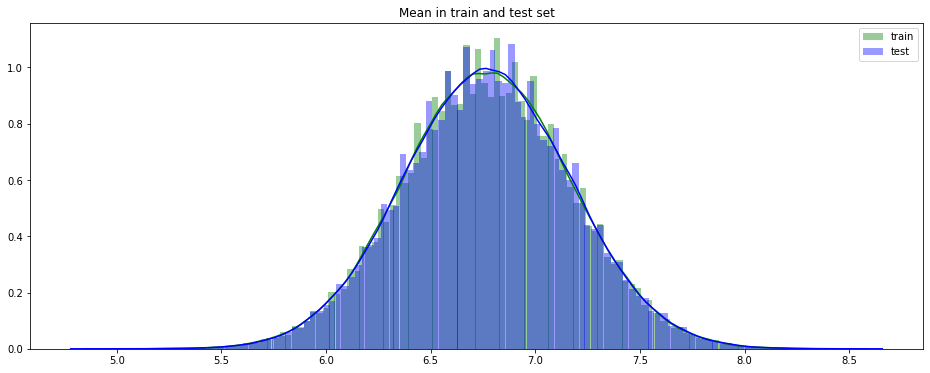

In [16]:
plt.figure(figsize=(16,6))
plt.title("Mean in train and test set")
sns.distplot(train[features].mean(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].mean(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

#### Standard Deviation

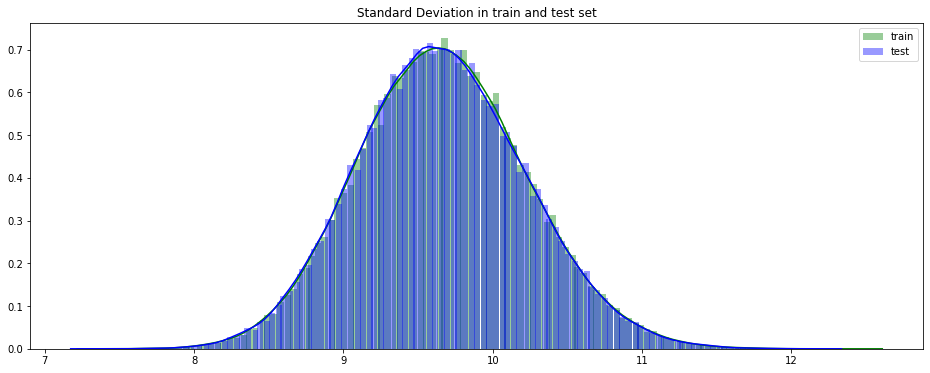

In [17]:
plt.figure(figsize=(16,6))
plt.title("Standard Deviation in train and test set")
sns.distplot(train[features].std(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].std(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

#### Skewness

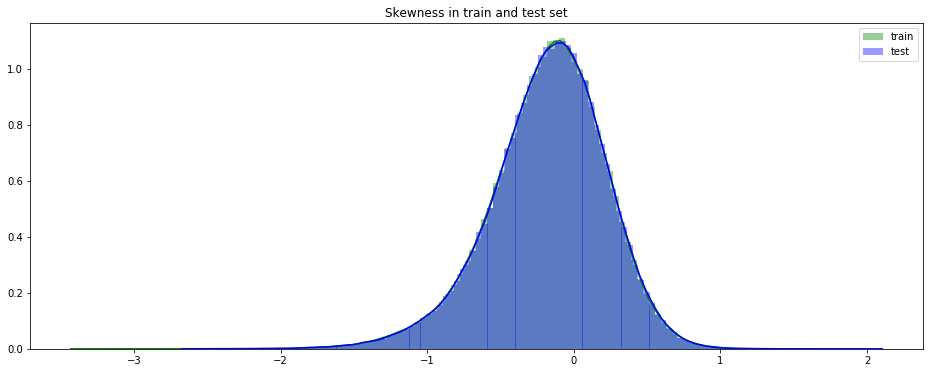

In [18]:
plt.figure(figsize=(16,6))
plt.title("Skewness in train and test set")
sns.distplot(train[features].skew(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].skew(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

#### Min

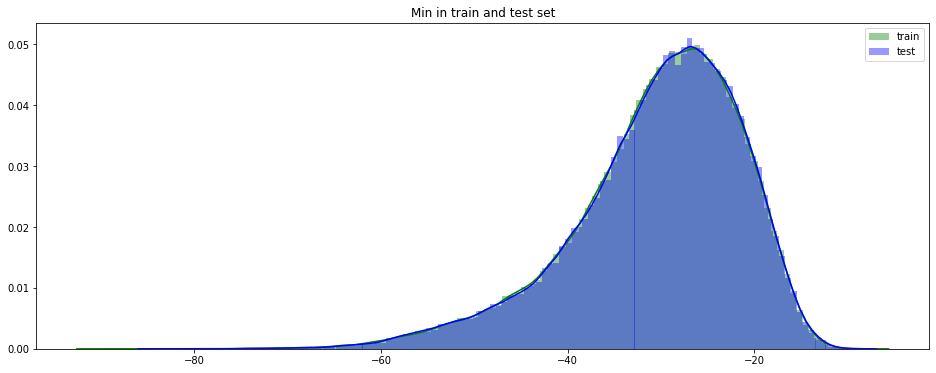

In [19]:
plt.figure(figsize=(16,6))
plt.title("Min in train and test set")
sns.distplot(train[features].min(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].min(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

#### Max

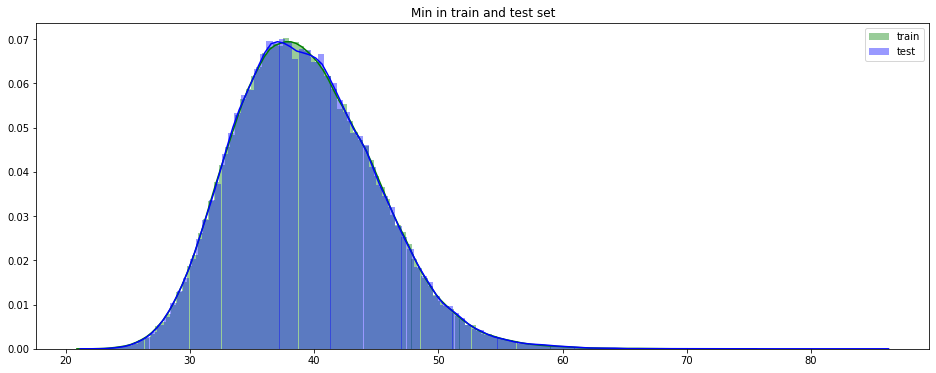

In [20]:
plt.figure(figsize=(16,6))
plt.title("Min in train and test set")
sns.distplot(train[features].max(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].max(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

#### Comparing Distribution of Feature

We can see from above that all the variables have nearly same distribution with the same scales

### Duplicate Values

In [21]:
features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [22]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,66,106,10,124,23,41,89,123,146,13,159,91,179,32,48
Feature,var_68,var_108,var_12,var_126,var_25,var_43,var_91,var_125,var_148,var_15,var_161,var_93,var_181,var_34,var_50
Max duplicates,40233,6127,3221,2746,2087,1836,1811,1780,1578,1431,1355,1191,1071,1060,922
Value,5.01953,14.2031,13.9766,11.5391,13.6875,11.5078,6.98438,12.5547,4.02344,14.625,5.60938,10.625,10.7969,11.5625,12.4922


In [23]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,66,106,10,124,23,41,89,123,146,13,159,91,32,179,48
Feature,var_68,var_108,var_12,var_126,var_25,var_43,var_91,var_125,var_148,var_15,var_161,var_93,var_34,var_181,var_50
Max duplicates,39964,5987,3164,2747,2116,1944,1848,1824,1617,1532,1387,1217,1088,1028,956
Value,5.01953,14.2031,13.9766,11.5391,13.6406,11.4609,7.03125,12.5391,4.00781,14.5156,5.74219,10.5312,11.4453,10.7969,12.6875


Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

# <a id='2'>Feature Engineering</a>  

In [24]:
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [25]:
train.head(2)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.62500,-4.921875,5.746094,...,12.781250,-1.091797,1454.0,-21.453125,43.1250,7.343750,9.320312,0.100464,NaN,6.773438
1,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.53125,3.146484,8.085938,...,18.359375,1.952148,1408.0,-47.375000,40.5625,7.109375,10.351562,-0.357422,NaN,7.222656


In [26]:
train.drop(['kurt'],axis=1,inplace=True)

In [27]:
train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_197,var_198,var_199,sum,min,max,mean,std,skew,med
0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,...,8.562500,12.781250,-1.091797,1454.0,-21.453125,43.12500,7.343750,9.320312,0.100464,6.773438
1,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,...,8.789062,18.359375,1.952148,1408.0,-47.375000,40.56250,7.109375,10.351562,-0.357422,7.222656
2,8.609375,-2.746094,12.078125,7.894531,10.585938,-9.085938,6.941406,14.617188,-4.917969,5.953125,...,8.265625,14.718750,0.396484,1235.0,-22.406250,33.87500,6.238281,8.773438,-0.063354,5.898438
3,11.062500,-2.152344,8.953125,7.195312,12.585938,-1.835938,5.843750,14.921875,-5.859375,8.242188,...,10.289062,17.968750,-9.000000,1279.0,-35.156250,38.09375,6.460938,9.617188,-0.484863,6.703125
4,9.835938,-1.483398,12.875000,6.636719,12.273438,2.449219,5.941406,19.250000,6.265625,7.679688,...,9.500000,18.000000,-8.812500,1346.0,-65.500000,41.09375,6.796875,11.328125,-1.469727,6.945312


In [28]:
test.head(2)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,test_0,11.06250,7.781250,12.953125,9.429688,11.429688,-2.380859,5.847656,18.265625,2.132812,...,15.46875,-8.71875,1398.0,-31.984375,42.03125,7.062500,9.953125,-0.081299,NaN,7.195312
1,test_1,8.53125,1.253906,11.304688,5.187500,9.195312,-4.011719,6.019531,18.625000,-4.414062,...,19.12500,-20.96875,1240.0,-41.187500,35.59375,6.261719,9.578125,-0.562012,NaN,6.437500


In [29]:
test.drop(['kurt','ID_code'],axis=1,inplace=True)

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train)

In [31]:
train_data.shape

(200000, 207)

# <a id='2'>Let's see if there are some correlations between our variables</a> 


In [64]:
# choose a threshold to spot correlation above its abs()
# try 0.08 or 0.05 to have some results, even though is not a relevant correlation 
threshold = 0.3
dfcorr = df_train.corr()
dfcorr1 = dfcorr.copy()
dfcorr1[abs(dfcorr1) < threshold] = None
dfcorr1[abs(dfcorr1) >= threshold] = 1

In [65]:
# all the variables have at least corr = 1 with itself so we want to know
# which variables have more than 1 record above the threshold
cor = dfcorr1.sum(axis=1) > 1

In [67]:
# Listing the variables that is worth investigating on
var_to_check = list(cor[cor.values == True].index)

In [68]:
if len(var_to_check) > 0:
    print('These are the variables with correlations >= {}:'.format(threshold))
    print(str(var_to_check) + '\n')
    for i in var_to_check:
        print(str(dfcorr[(abs(dfcorr[i]) >= threshold) & (abs(dfcorr[i]) != 1)][i]) + '\n')
else:
    print('There are no significant correlations to look!')

There are no significant correlations to look!


In [69]:
dfcorr[(dfcorr!=1) & (abs(dfcorr)>0.1)].count()

target     0
var_0      0
var_1      0
var_2      0
var_3      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 201, dtype: int64

All the correlations are < |0.1| ... They are extremely uncorrelated.

Maybe Santander team had preprocessed the data!

# <a id='2'>Modelling</a>  

### Regression Model

## Light GBM

In [33]:
!pip install lightgbm

In [34]:
import lightgbm as lgb

In [35]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

#njobs = -1

In [37]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train
#https://www.kaggle.com/ashishpatel26/kfold-lightgbm/code 
#(learned from here how to use stratified k-fold with model)
#https://github.com/KazukiOnodera/Santander-Customer-Transaction-Prediction/blob/master/final_solution/onodera/py/907_predict_0410-2.py

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, labels.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=labels.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=labels.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(labels, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.898416	valid_1's auc: 0.879423
[2000]	training's auc: 0.909095	valid_1's auc: 0.886415
[3000]	training's auc: 0.916569	valid_1's auc: 0.890816
[4000]	training's auc: 0.922256	valid_1's auc: 0.893047
[5000]	training's auc: 0.926935	valid_1's auc: 0.894655
[6000]	training's auc: 0.931187	valid_1's auc: 0.895585
[7000]	training's auc: 0.935173	valid_1's auc: 0.896432
[8000]	training's auc: 0.938821	valid_1's auc: 0.896624
[9000]	training's auc: 0.942428	valid_1's auc: 0.896811
[10000]	training's auc: 0.945787	valid_1's auc: 0.896703
[11000]	training's auc: 0.949007	valid_1's auc: 0.896715
[12000]	training's auc: 0.952091	valid_1's auc: 0.896705
Early stopping, best iteration is:
[9295]	training's auc: 0.94345	valid_1's auc: 0.896898
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.898197	valid_1's auc: 0.880849
[2000]	training's auc: 0.908856	valid

[8000]	training's auc: 0.938976	valid_1's auc: 0.898245
[9000]	training's auc: 0.942555	valid_1's auc: 0.898286
[10000]	training's auc: 0.946015	valid_1's auc: 0.898298
[11000]	training's auc: 0.949268	valid_1's auc: 0.89821
[12000]	training's auc: 0.952388	valid_1's auc: 0.898177
Early stopping, best iteration is:
[9874]	training's auc: 0.945576	valid_1's auc: 0.898367
CV score: 0.89728 


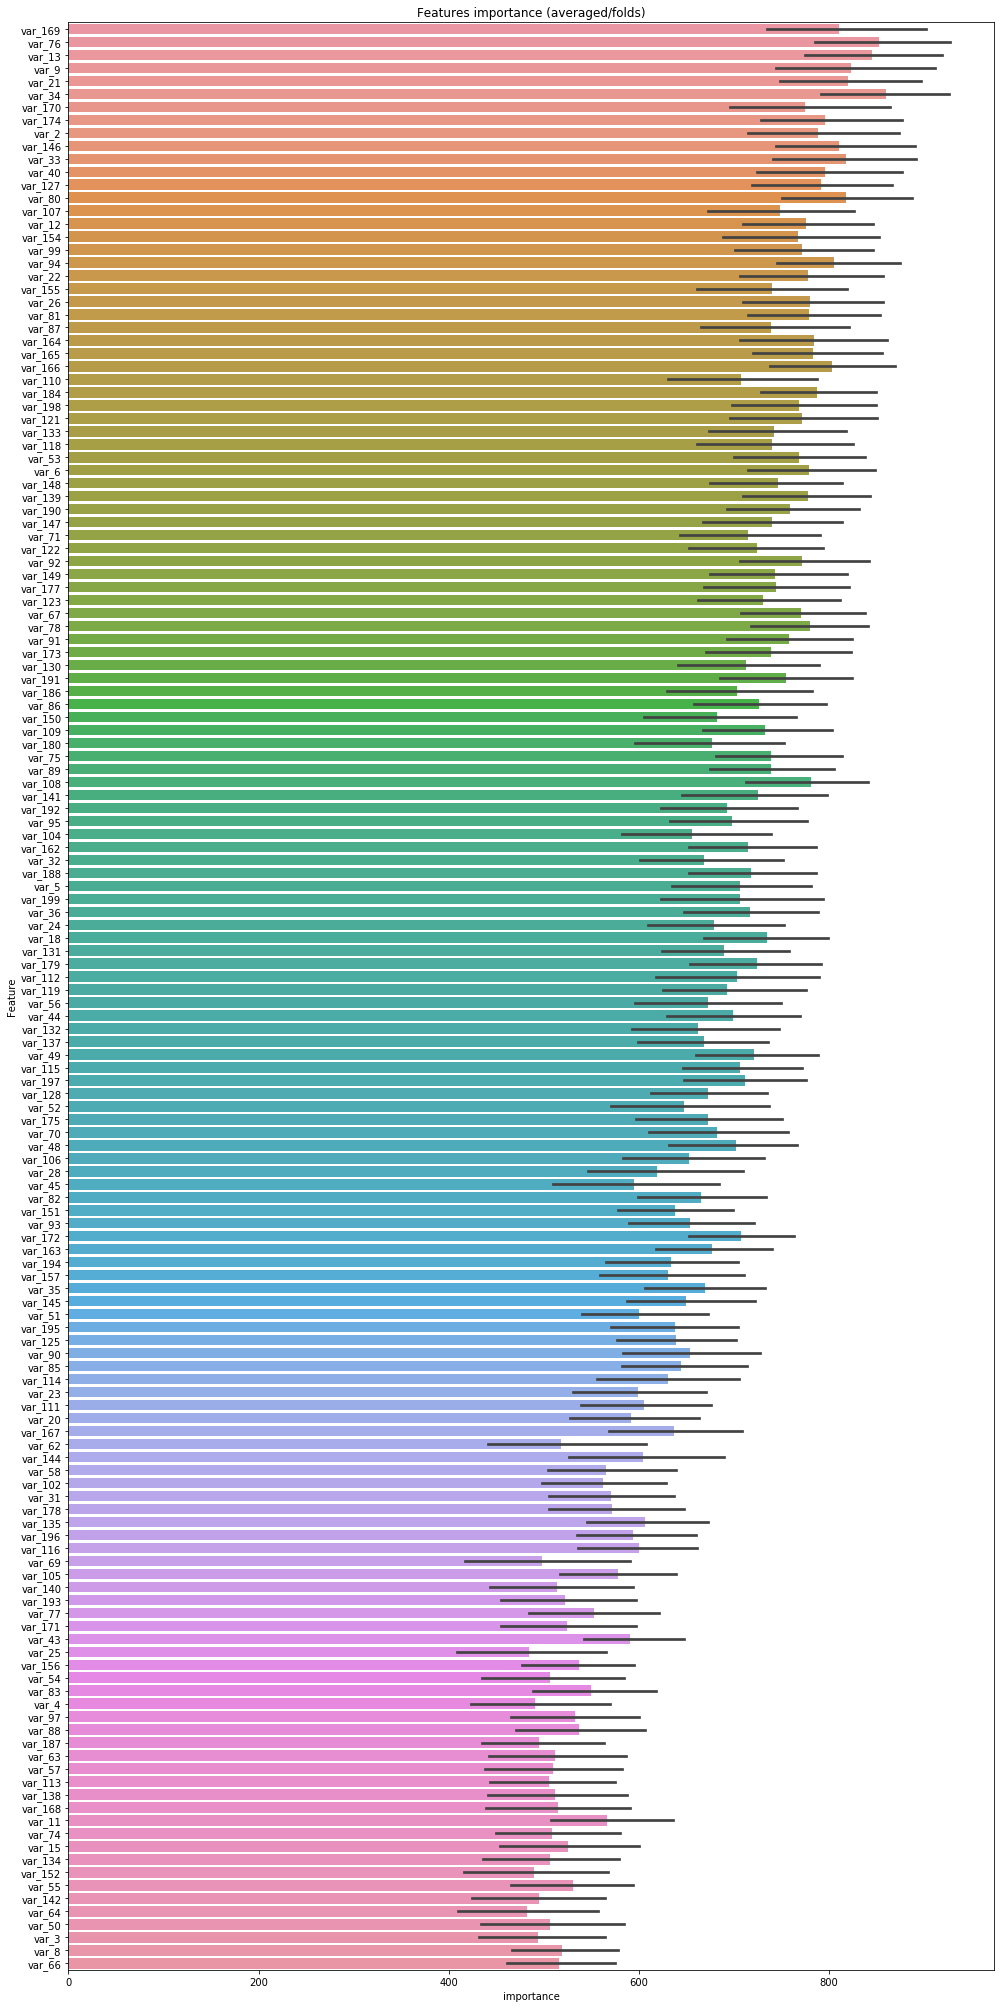

In [38]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

### Classification Model

### 1. Logistic Regression

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from random import randrange, uniform
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
trans = pd.read_csv("C:/Users/shali/Desktop/INFO 7390/Assignments/Assignment2/Data/test.csv")

### Detect and delete outliers from data

In [3]:
for i in range(2,202):
        #print(i)
        q75, q25 = np.percentile(trans.iloc[:,i], [75 ,25])
        iqr = q75 - q25

        min = q25 - (iqr*1.5)
        max = q75 + (iqr*1.5)
        #print(min)
        #print(max)
       
        trans = trans.drop(trans[trans.iloc[:,i] < min].index)
        trans = trans.drop(trans[trans.iloc[:,i] > max].index)

In [4]:
trans.shape

(175073, 202)

{'whiskers': [<matplotlib.lines.Line2D at 0x1ea8f073908>,
 'caps': [<matplotlib.lines.Line2D at 0x1ea8f073da0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1ea8f0736d8>],
 'medians': [<matplotlib.lines.Line2D at 0x1ea8f29c470>],
 'fliers': [<matplotlib.lines.Line2D at 0x1eac8070080>],
 'means': []}

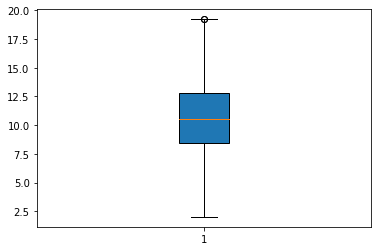

In [6]:
plt.boxplot(trans['var_0'] ,vert=True,patch_artist=True)

In [7]:
trans = trans.drop(trans.columns[0], axis = 1)

In [8]:
from  sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(trans.drop('target',axis=1), 
                                                    trans['target'], test_size=0.30, 
                                                    random_state=101)

In [9]:
print(x_train.shape)
print(x_test.shape)

(122551, 200)
(52522, 200)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from math import log

Printing parameter Data and Corresponding Log value
   Parameter value  Corresponding Log Value
0           0.0001                -4.000000
1           0.0010                -3.000000
2           0.0100                -2.000000
3           0.1000                -1.000000
4           1.0000                 0.000000
5           5.0000                 0.698970
6          10.0000                 1.000000
7          20.0000                 1.301030
8          30.0000                 1.477121
9          40.0000                 1.602060


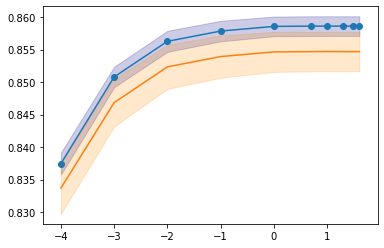

In [11]:
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV

C = LogisticRegression()

import math

parameter_data = [0.0001,0.001,0.01,0.1,1,5,10,20,30,40]

log_my_data = [math.log10(x) for x in parameter_data]

#print(log_my_data)
print("Printing parameter Data and Corresponding Log value")
data={'Parameter value':parameter_data,'Corresponding Log Value':log_my_data}
param=pd.DataFrame(data)
print("="*100)
print(param)
parameters = {'C':parameter_data}
clf = RandomizedSearchCV(C, parameters, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(x_train, y_train)

#data={'Parameter value':[0.0001,0.001,0.01,0.1,1,5,10,20,30,40],'Corresponding Log Value':[log_my_data]}

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(log_my_data, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_my_data,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_my_data, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_my_data,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_my_data, train_auc, label='Train AUC points')

In [14]:
def model_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    y_data_pred.extend(clf.predict_proba(data[:])[:,1])
  
    return y_data_pred

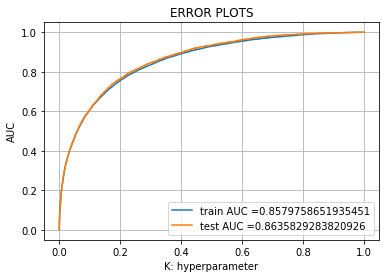

In [23]:
from sklearn.metrics import roc_curve, auc


neigh = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model_predict(neigh, x_train)    
y_test_pred = model_predict(neigh, x_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_test_pred)
CM = pd.crosstab(y_test, y_test_pred)

#let us save TP, TN, FP, FN
TN = CM.iloc[0,0]
FN = CM.iloc[1,0]
TP = CM.iloc[1,1]
FP = CM.iloc[0,1]

Text(0.5, 1, 'Confusion Matrix')

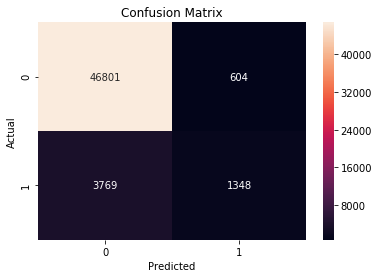

In [43]:
sns.heatmap(CM, annot=True, fmt="d" )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")

In [44]:
test =pd.read_csv("test.csv")

In [45]:
id_code = test.iloc[:,0]

In [46]:
test = test.drop("ID_code" ,axis=1)
predictions_test = neigh.predict(test)
df = pd.DataFrame({"ID_code" :id_code ,"target": predictions_test})
df.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [47]:
test_logistic = df.join(test)
test_logistic.to_csv('logisticmodelpred.csv')
test_logistic.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,0,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,0,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,0,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,0,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


0    194098
1      5902
Name: target, dtype: int64

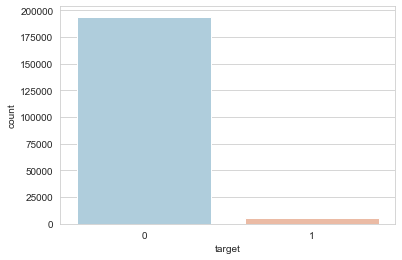

In [48]:
sns.set_style('whitegrid')
sns.countplot(x='target',data=test_logistic,palette='RdBu_r')
test_logistic['target'].value_counts()

### Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

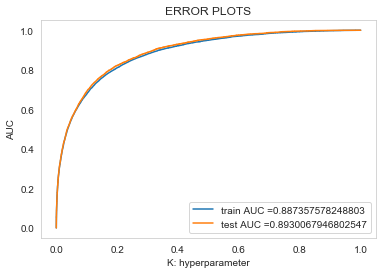

In [58]:
neigh = GaussianNB()
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model_predict(neigh, x_train)    
y_test_pred = model_predict(neigh, x_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Text(0.5, 1, 'Confusion Matrix')

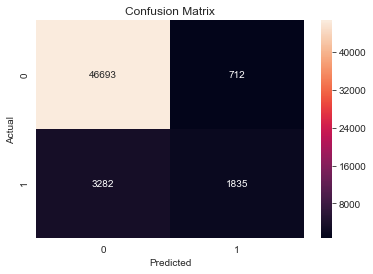

In [63]:
CM = confusion_matrix(y_test, y_test_pred)
CM = pd.crosstab(y_test, y_test_pred)

#let us save TP, TN, FP, FN
TN = CM.iloc[0,0]
FN = CM.iloc[1,0]
TP = CM.iloc[1,1]
FP = CM.iloc[0,1]
sns.heatmap(CM, annot=True, fmt="d" )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")

In [65]:
predictions_test = neigh.predict(test)

In [67]:
df = pd.DataFrame({"ID_code" :id_code ,"target": predictions_test})
df.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [68]:
test_nb = df.join(test)

In [69]:
test_nb.head(2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,0,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760


0    192096
1      7904
Name: target, dtype: int64

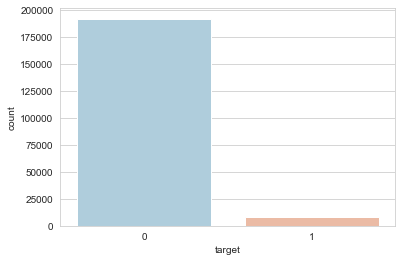

In [70]:
sns.set_style('whitegrid')
sns.countplot(x='target',data=test_nb,palette='RdBu_r')
test_nb['target'].value_counts()

In [71]:
test_nb.to_csv('Naive Bayes Prediction.csv')

### Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

C = RandomForestClassifier()

n_estimators=[10,50,100,200]
max_depth=[1, 5, 10, 50]

import math

log_max_depth = [math.log10(x) for x in max_depth]
log_n_estimators=[math.log10(x) for x in n_estimators]

print("Printing parameter Data and Corresponding Log value for Max Depth")
data={'Parameter value':max_depth,'Corresponding Log Value':log_max_depth}
param=pd.DataFrame(data)
print("="*100)
print(param)

print("Printing parameter Data and Corresponding Log value for Estimators")
data={'Parameter value':n_estimators,'Corresponding Log Value':log_n_estimators}
param=pd.DataFrame(data)
print("="*100)
print(param)

parameters = {'n_estimators':n_estimators, 'max_depth':max_depth}
clf = GridSearchCV(C, parameters, cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1)
clf.fit(x_train, y_train)

#data={'Parameter value':[0.0001,0.001,0.01,0.1,1,5,10,20,30,40],'Corresponding Log Value':[log_my_data]}

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

Printing parameter Data and Corresponding Log value for Max Depth
   Parameter value  Corresponding Log Value
0                1                  0.00000
1                5                  0.69897
2               10                  1.00000
3               50                  1.69897
Printing parameter Data and Corresponding Log value for Estimators
   Parameter value  Corresponding Log Value
0               10                  1.00000
1               50                  1.69897
2              100                  2.00000
3              200                  2.30103


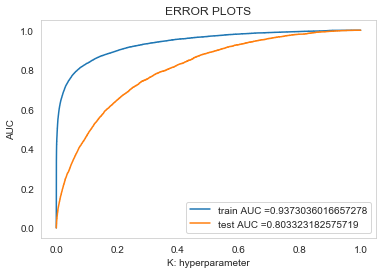

In [76]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
#from sklearn.calibration import CalibratedClassifierCV


neigh = RandomForestClassifier(n_estimators=100,max_depth=10,class_weight='balanced')
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model_predict(neigh, x_train)   
y_test_pred = model_predict(neigh, x_test)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Text(0.5, 1, 'Confusion Matrix')

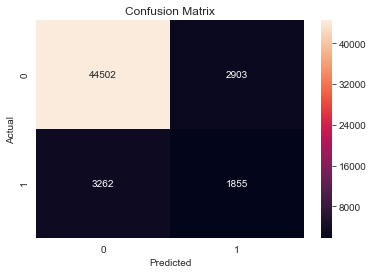

In [78]:
CM = confusion_matrix(y_test, y_test_pred)
CM = pd.crosstab(y_test, y_test_pred)

#let us save TP, TN, FP, FN
TN = CM.iloc[0,0]
FN = CM.iloc[1,0]
TP = CM.iloc[1,1]
FP = CM.iloc[0,1]
sns.heatmap(CM, annot=True, fmt="d" )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")

In [79]:
predictions_rfc = neigh.predict(test)

In [80]:
df = pd.DataFrame({"ID_code" :id_code ,"target": predictions_rfc})
df.head()

,ID_code,target
0,test_0,1
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [81]:
test_rfc = df.join(test)

0    182954
1     17046
Name: target, dtype: int64

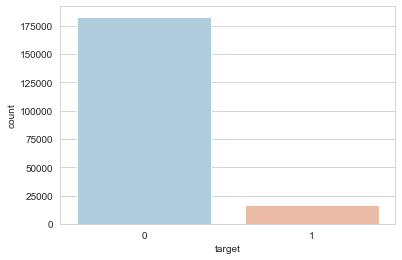

In [82]:
sns.set_style('whitegrid')
sns.countplot(x='target',data=test_rfc,palette='RdBu_r')
test_rfc['target'].value_counts()

In [83]:
test_rfc.to_csv('RandomForestPrediction.csv')

# <a i> Predictive Analysis & Model Tuning </a>

At this point, what did I know?

1) Regular transformations wouldn't work (many topics shared failed experiments).

2) The test dataset had fake data, and that was relevant.

3) That unique values were, somehow, important.

So I decided to experiment with both of these ideas: I merged the train and test datataset without fake values, created new columns for each variable with the number of unique values in it, and trained my model.

 
SETTING FEATURE FRACTION TO 1

Feature fraction is a parameter of the LGB model. It goes from 0 to 1 and represents the percentage of the data that you will use on each iteration of the traning. My feature fraction was 0.3. When I set it to 1, the model was able to look at all the variables at once, and voila: CV 0.899

TIP: Setting feature fraction to 1 is a great way to understand the impact of a new feature in your model.






In [14]:
df_train = train.copy()
df_test = test.copy()

In [15]:
print("Train shape: " + str(df_train.shape))
print("Test shape: " + str(df_test.shape))

Train shape: (200000, 202)
Test shape: (200000, 201)


In [16]:
# Splitting the target variable and the features
X_train = df_train.loc[:,'var_0':]
y_train = df_train.loc[:,'target']

In [17]:
print(X_train.shape)
print(y_train.shape)

(200000, 200)
(200000,)


## Sorting Fake Test Data

After saw a discussion on Kaggle. It seems that the test dataset was created with half real data (used for LB scores) and synthetic data (maybe to increase the diffuculty of the competition). Note that this was one of the most important kernel of the competition, so it is worth looking it :)

Reference https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

In [5]:
import pandas as pd
synthetic_samples_indexes = pd.read_csv('C:/Users/shali/Desktop/INFO 7390/Assignments/Assignment2/Data/synthetic_samples_indexes.csv')

In [18]:
df_test_real = test.copy()
df_test_real = df_test_real[~df_test_real.index.isin(list(synthetic_samples_indexes['synthetic_samples_indexes']))]
X_test = df_test_real.loc[:,'var_0':]
X_test.shape

(100000, 200)

# <a id='2'>Now let's plot density graphs</a>

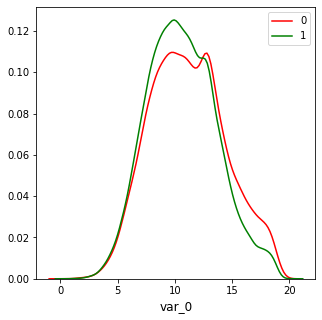

In [74]:
fig = plt.figure(figsize=(5,5))
sns.distplot(df_train[df_train['target']>0]['var_0'], hist=False,label='0', color='red')
sns.distplot(df_train[df_train['target']==0]['var_0'], hist=False,label='1', color='green')
plt.xlabel('var_0', fontsize=12)
locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=10)

#balanced output

## Frequency Encoding


As discussed in the EDA notebook frequency encoding may help our tree based model to learn also the values occurrences for each variable.
https://www.kaggle.com/cdeotte/200-magical-models-santander-0-920

I tried both considering only the training set and concatenating train + test.

The second path takes significant advantages in terms of performance!


**MAKING MY JOB EASIER using Frequency Encoding**

At this point, I had a problem to solve: Each new feature about values frequency only mattered for one other specific feature. My model, however, was checking all possible interactions between my 400 features and taking a long time to run.


So I decided train my model with 2 features at a time: The original one and an extra column with the unique values count.

In [19]:
def get_count(df):
    '''
    Function that adds one column for each variable (excluding 'ID_code', 'target')
    populated with the value frequencies
    '''
    for var in [i for i in df.columns if i not in ['ID_code','target']]:
        df[var+'_count'] = df.groupby(var)[var].transform('count')
    return df

In [20]:
X_tot = pd.concat([X_train, X_test])
print(X_tot.shape)

(300000, 200)


In [22]:
import time
start = time.time()
X_tot = get_count(X_tot)
end = time.time()
print('It took %.2f seconds\nShape: ' %(end - start))
print(X_tot.shape)

It took 65.36 seconds
Shape: 
(300000, 400)


In [23]:
X_train_count = X_tot.iloc[0:200000]
X_test_count = X_tot.iloc[200000:]

In [84]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1, color='red')
        sns.distplot(df2[feature], hist=False,label=label2, color='green')
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

<Figure size 432x288 with 0 Axes>

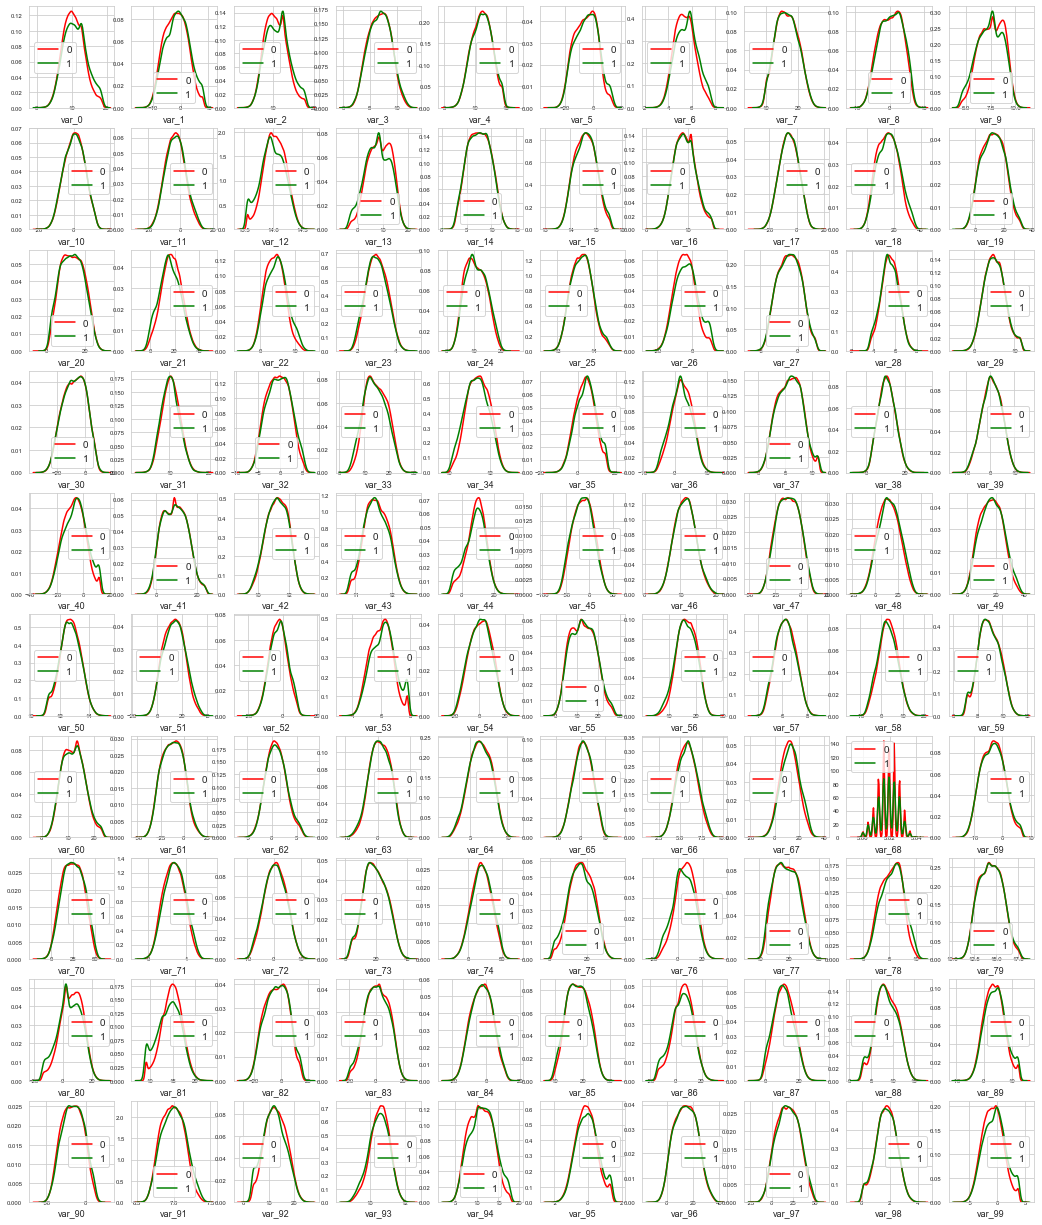

In [85]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
features = df_train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

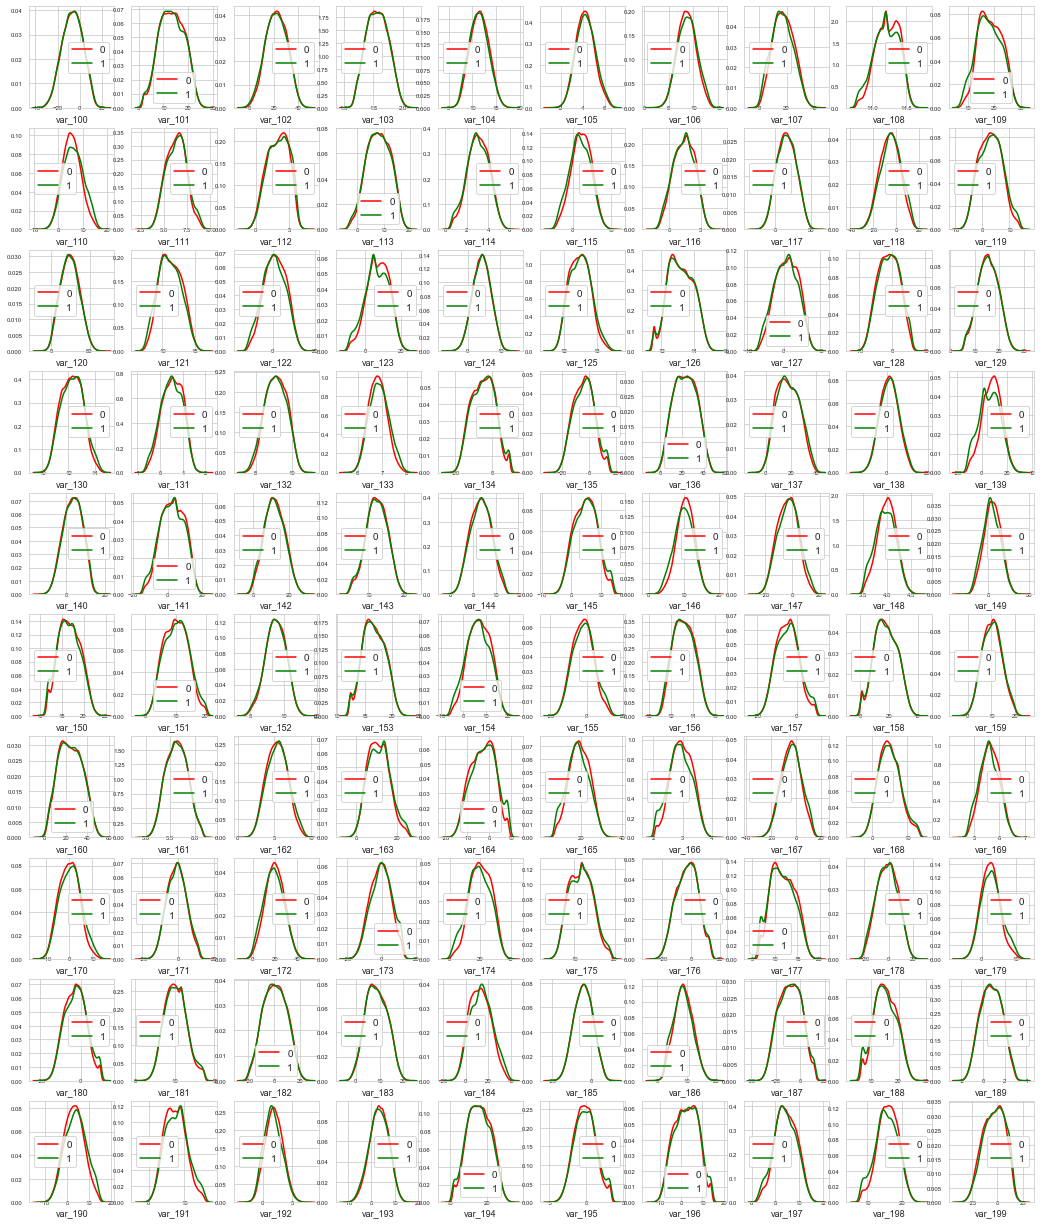

In [87]:
features = df_train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

# Let's build Model
But first let's split the train set into training and validation

In [25]:
# Libraries
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import lightgbm as lgb

In [26]:
# 0.8 train, 0.2 dev
X_train,X_valid,y_train,y_valid = train_test_split(X_train_count, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [27]:
print('X_train shape: {}\n'.format(X_train.shape))
print('y_train shape: {}\n'.format(y_train.shape))
print('X_valid shape: {}\n'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

X_train shape: (160000, 400)

y_train shape: (160000,)

X_valid shape: (40000, 400)

y_valid shape: (40000,)


## Data Augmentation


Augmentation is a method to increase the amount of training data by randomly shuffle/transform the features in a certain way. It improves accuracy by letting the model see more cases of both "1" and "0" samples in training so the model can generalize better to new data.

I will tend to summarise that this technique works, when:

a. Number of features are large

b. No feature is strongly correlated with target (which is the case in my example)

c. Correlations among features is also low

I augmented both 1 and 0 training samples and tune the amount of augmentation. Currently, my best parameter is to add 2x "1"s and 1x "0"s.

In [28]:
# Data Augmentation 2x if y = 1 , 1x if y = 0
#Reference
#https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment

def augment(x,y,t=2):
    '''
    Data Augmentation 2x if y = 1 , 1x if y = 0
    '''
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(int(x1.shape[1]/2)):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
            x1[:,c+200] = x1[ids][:,c+200] # The new features must go with their original one!
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(int(x1.shape[1]/2)):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
            x1[:,c+200] = x1[ids][:,c+200] # The new features must go with their original one!
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [29]:
start = time.time()
# Trying Augmentation Only for training set!
X_tr, y_tr = augment(X_train.values, y_train.values)
print('X_tr Augm shape: {}'.format(X_tr.shape))
print('y_tr Augm shape: {}'.format(y_tr.shape))

end = time.time()
print('It took %.2f seconds' %(end - start))

X_tr Augm shape: (336078, 400)
y_tr Augm shape: (336078,)
It took 283.63 seconds


In [30]:
X_tr = pd.DataFrame(data=X_tr,columns=X_train.columns)
y_tr = pd.DataFrame(data=y_tr)

In [32]:
y_tr.columns = ['target']

In [33]:
# List of all the features
features = [c for c in X_train.columns if c not in ['ID_code', 'target']]

In [34]:
# The parameters for Light Gradient Boost
lgb_params = {
        'bagging_fraction': 0.77,
        'bagging_freq': 2,
        'lambda_l1': 0.7,
        'lambda_l2': 2,
        'learning_rate': 0.01,
        'max_depth': 3,
        'min_data_in_leaf': 22,
        'min_gain_to_split': 0.07,
        'min_sum_hessian_in_leaf': 19,
        'num_leaves': 20,
        'feature_fraction': 1,
        'save_binary': True,
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': 'false',
        'num_threads': 6
}

Less than 6 min with my pc! That's fast :)

In [36]:
val_pred = (y_hat).sum(axis=1)/200
predictions = (test_hat).sum(axis=1)/200
score = roc_auc_score(y_valid, val_pred)
print('>>> Your CV score is: ', score)

>>> Your CV score is:  0.897443839723008


###  With Augmentation

In [37]:
start = time.time()

iteration = 120
y_hat = np.zeros([int(200000*0.2), 200])
test_hat = np.zeros([100000, 200])
i = 0
for feature in ['var_' + str(x) for x in range(200)]: # loop over all the raw features
    feat_choices = [feature, feature + '_count']
    trn_data = lgb.Dataset(X_tr[feat_choices], y_tr) # Augmentation
    val_data = lgb.Dataset(X_valid[feat_choices], y_valid)
    clf = lgb.train(lgb_params, trn_data, iteration, valid_sets=[val_data], verbose_eval=-1)
    y_hat[:, i] = clf.predict(X_valid[feat_choices])
    test_hat[:, i] = clf.predict(X_test_count[feat_choices])
    i += 1
    
end = time.time()
print('It took %.2f seconds' %(end - start))

It took 328.78 seconds


In [38]:
val_pred = (y_hat).sum(axis=1)/200
predictions = (test_hat).sum(axis=1)/200
score = roc_auc_score(y_valid, val_pred)
print('>>> Your CV score is: ', score)

>>> Your CV score is:  0.8963278728646926


I tried both with and without Augmentation. These are the results:

No Augm: CV: 0.8974
Augm: CV: 0.8963

# MY FINAL RUN WITH 4 FOLD

# KFold CV

Let's try to split  Training set with KFold cross validation. This should help us to increase a bit our performances and to have more reliable results!

I choose 4 Fold, but this could be changed!

In [51]:
folds = KFold(n_splits=4, random_state=42)
target = df_train['target']
y_hat = np.zeros([200000, 200])
test_hat = np.zeros([100000, 200])
i = 0
start = time.time()
for feature in ['var_' + str(x) for x in range(200)]: # loop over all features 
    feat_choices = [feature, feature + '_count']
    print('Model using: ' + str(feat_choices))
    oof = np.zeros(len(X_train_count))
    predictions = np.zeros(len(X_test_count))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_count[feat_choices].values, target.values)):
        trn_data = lgb.Dataset(X_train_count.iloc[trn_idx][feat_choices], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(X_train_count.iloc[val_idx][feat_choices], label=target.iloc[val_idx])
        clf = lgb.train(lgb_params, trn_data, 130, valid_sets = [val_data], verbose_eval=-1)
        oof[val_idx] = clf.predict(X_train_count.iloc[val_idx][feat_choices])
        predictions += clf.predict(X_test_count[feat_choices]) / folds.n_splits
    print(">>> CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
    
    y_hat[:, i] = oof
    test_hat[:, i] = predictions
    i += 1

    
end = time.time()
print('It took %.2f seconds' %(end - start))

Model using: ['var_0', 'var_0_count']
>>> CV score: 0.54152 
Model using: ['var_1', 'var_1_count']
>>> CV score: 0.54246 
Model using: ['var_2', 'var_2_count']
>>> CV score: 0.54928 
Model using: ['var_3', 'var_3_count']
>>> CV score: 0.50922 
Model using: ['var_4', 'var_4_count']
>>> CV score: 0.50429 
Model using: ['var_5', 'var_5_count']
>>> CV score: 0.52633 
Model using: ['var_6', 'var_6_count']
>>> CV score: 0.55766 
Model using: ['var_7', 'var_7_count']
>>> CV score: 0.50113 
Model using: ['var_8', 'var_8_count']
>>> CV score: 0.51643 
Model using: ['var_9', 'var_9_count']
>>> CV score: 0.54168 
Model using: ['var_10', 'var_10_count']
>>> CV score: 0.50259 
Model using: ['var_11', 'var_11_count']
>>> CV score: 0.51664 
Model using: ['var_12', 'var_12_count']
>>> CV score: 0.55860 
Model using: ['var_13', 'var_13_count']
>>> CV score: 0.55204 
Model using: ['var_14', 'var_14_count']
>>> CV score: 0.50484 
Model using: ['var_15', 'var_15_count']
>>> CV score: 0.51292 
Model using:

>>> CV score: 0.50149 
Model using: ['var_130', 'var_130_count']
>>> CV score: 0.52483 
Model using: ['var_131', 'var_131_count']
>>> CV score: 0.52804 
Model using: ['var_132', 'var_132_count']
>>> CV score: 0.51997 
Model using: ['var_133', 'var_133_count']
>>> CV score: 0.54489 
Model using: ['var_134', 'var_134_count']
>>> CV score: 0.51243 
Model using: ['var_135', 'var_135_count']
>>> CV score: 0.52292 
Model using: ['var_136', 'var_136_count']
>>> CV score: 0.49988 
Model using: ['var_137', 'var_137_count']
>>> CV score: 0.52469 
Model using: ['var_138', 'var_138_count']
>>> CV score: 0.51417 
Model using: ['var_139', 'var_139_count']
>>> CV score: 0.56320 
Model using: ['var_140', 'var_140_count']
>>> CV score: 0.51180 
Model using: ['var_141', 'var_141_count']
>>> CV score: 0.52664 
Model using: ['var_142', 'var_142_count']
>>> CV score: 0.51696 
Model using: ['var_143', 'var_143_count']
>>> CV score: 0.50349 
Model using: ['var_144', 'var_144_count']
>>> CV score: 0.51659 
Mo

 Well, almost 36 min from my pc. It's quite good!

Please note that when I tried KFold CV with all the raw features it took several hours!

In [52]:
valid_pred = (y_hat).sum(axis=1)/200
predictions = (test_hat).sum(axis=1)/200
print('>>> Your CV score is:', roc_auc_score(target, valid_pred))

>>> Your CV score is: 0.8959287651285126


This is the best result I achieved  0.89, but I am grateful for this experience.


4 KFold Results:

CV: 0.8959

# Kaggle Score Evaluation

Public Score: 0.92223

Private Score: 0.92057

Kaggle Rank Public leaderboard is 62 out of 8820 i.e 0.007

# Conclusion

After applying multiple models (Logistic, Decision Tree, random Forest, Naive Bayes and LGB) based on sampling using Sorting Fake test data, Frequency Encoding and KFold CV.LGB given maximum score from these models.

# Submission

Preparing the submission file!

We only need 'ID_codes' and 'pred' columns.

Note that I predicted values only for the real test data and I setted the fake ones at 0.

In [53]:
subm = pd.DataFrame({"ID_codes":df_test[~df_test.index.isin(list(synthetic_samples_indexes['synthetic_samples_indexes']))].loc[:,'ID_code']})
subm['pred'] = predictions
subm.head()

,ID_codes,pred
3,test_3,0.500704
7,test_7,0.500342
11,test_11,0.498372
15,test_15,0.498475
16,test_16,0.500413


In [54]:
ID_codes = df_test[~df_test.index.isin(list(synthetic_samples_indexes['synthetic_samples_indexes']))].loc[:,'ID_code']
submission = pd.DataFrame({"ID_code": df_test.ID_code.values})
submission['target'] = 0
submission.loc[submission['ID_code'].isin(ID_codes), 'target'] = subm['pred'].values

In [55]:
submission.head()

,ID_code,target
0,test_0,0.000000
1,test_1,0.000000
2,test_2,0.000000
3,test_3,0.500704
4,test_4,0.000000


In [56]:
submission.to_csv(r'submission.csv', index = None, header=True)

**MIT License**

Copyright (C) 2020 Shalini Chandra

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.